<h2>Hyperelasticity equation and problem definition</h2>
<p>By definition, boundary value problems for hyperelastic media can be expressed as minimisation problems, and the minimization approach is adopted in this example. For a domain $\Omega \subset \mathbb{R}^{d}$, where $d$ denotes the spatial dimension, the task is to find the displacement field $u: \Omega \rightarrow \mathbb{R}^{d}$ that minimises the total potential energy $\Pi$:</p>

$$\min_{u \in V} \Pi,$$
<p>where $V$ is a suitable function space that satisfies boundary conditions on $u$.  The total potential energy is given by</p>

$$\Pi = \int_{\Omega} \psi(u) \, {\rm d} x - \int_{\Omega} B \cdot u \, {\rm d} x - \int_{\partial\Omega} T \cdot u \, {\rm d} s,$$
<p>where $\psi$ is the elastic stored energy density, $B$ is a
body force (per unit reference volume) and $T$ is a traction force
(per unit reference area).</p>

<p>At minimum points of $\Pi$, the directional derivative of $\Pi$ with respect to change in $u$</p>
$$L(u; v) = D_{v} \Pi = \left. \frac{d \Pi(u + \epsilon v)}{d\epsilon} \right|_{\epsilon = 0}$$
<p>is equal to zero for all $v \in V$:</p>

$$L(u; v) = 0 \quad \forall \ v \in V.$$
<p>To minimise the potential energy, a solution to the variational equation above is sought. Depending on the potential energy $\psi$, $L(u; v)$ can be nonlinear in $u$. In such a case, the Jacobian of $L$ is required in order to solve this
problem using Newton's method. The Jacobian of $L$ is defined as</p>

$$a(u; du, v) = D_{du} L = \left. \frac{d L(u + \epsilon du; v)}{d\epsilon} \right|_{\epsilon = 0} .$$

<h3>Elastic stored energy density</h3>
<p>To define the elastic stored energy density, consider the deformation gradient $F$</p>

$$F = I + \nabla u,$$
<p>the right Cauchy-Green tensor $C$</p>

$$C = F^{T} F,$$
<p>and the scalars  $J$ and $I_{c}$</p>

$$\begin{split}J     &= \det(F), \\
I_{c} &= {\rm trace}(C).\end{split}$$
<p>This demo considers a common neo-Hookean stored energy model of the form</p>

$$\psi =  \frac{\mu}{2} (I_{c} - 3) - \mu \ln(J) + \frac{\lambda}{2}\ln(J)^{2},$$
<p>where $\mu$ and $\lambda$ are the Lame parameters. These can be expressed in terms of the more common Young's modulus $E$
and Poisson ratio $\nu$ by:</p>

$$\lambda = \frac{E \nu}{(1 + \nu)(1 - 2\nu)}, \quad  \quad \mu     =  \frac{E}{2(1 + \nu)} .$$


# Test: Beam under uniform stress
See Linear Elasticity notebook for details.

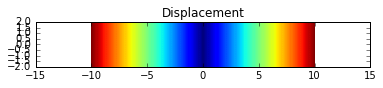

In [84]:
%matplotlib inline
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
import os 

# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

# Create mesh and define function space
nx, ny = 200, 20
mesh = RectangleMesh(Point(-10, -2), Point(10, 2), nx, ny)
V = VectorFunctionSpace(mesh, "Lagrange", 1)

# Mark boundary subdomians
tol = 1e-14
def boundary_x(x, on_boundary): return abs(x[0]) < tol 
bcx = DirichletBC(V.sub(0), Constant(0.0), boundary_x)
def boundary_y(x, on_boundary): return abs(x[1]) < tol 
bcy = DirichletBC(V.sub(1), Constant(0.0), boundary_y)
bcs = [bcx,bcy]

# Define functions
du = TrialFunction(V)            # Incremental displacement
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement from previous iteration
B  = Constant((0.0, 0.0))  # Body force per unit volume
T = Expression((('.01','0'),('0','0')))
n = FacetNormal(mesh)

# Kinematics
I = Identity(2)             # Identity tensor
F = I + grad(u)             # Deformation gradient
C = F.T*F                   # Right Cauchy-Green tensor

# Invariants of deformation tensors
Ic = tr(C)
J  = det(F)

# Elasticity parameters
G, lam = 1.0, .001
nu = lam/(2*(lam+G))
E = lam*(1+nu)*(1-2*nu)/nu

# Stored strain energy density (compressible neo-Hookean model)
psi = (G/2)*(Ic - 2) - G*ln(J) + (lam/2)*(ln(J))**2

# Total potential energy
Pi = psi*dx - dot(B, u)*dx - dot(T*n, u)*ds

# Compute first variation of Pi (directional derivative about u in the direction of v)
F = derivative(Pi, u, v)

# Compute Jacobian of F
J = derivative(F, u, du)

# Solve variational problem    
solve(F == 0, u, bcs, J=J, form_compiler_parameters=ffc_options)

# Save solution in VTK format
os.system('rm ./hyper/*')
u.rename("hyper_disp","")
ufile = XDMFFile('hyper/hyper_u.xdmf')
ufile.write(u,0)
del ufile

# Plot and hold solution
plt.figure()
plot(u, title='Displacement', mode='displacement')

# Test: Hyper vs. Linear Elasticity (displacement plot)

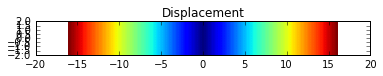

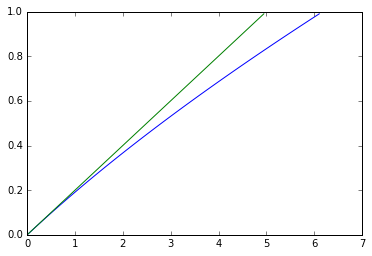

In [86]:
max_disp = []
for i in range(0,10000,100):
    # Traction
    T = Expression((('t','0'),('0','0')),degree=2,t=i/10000.0)
    
    # Total potential energy
    Pi = psi*dx - dot(B, u)*dx - dot(T*n, u)*ds

    # Compute first variation of Pi (directional derivative about u in the direction of v)
    F = derivative(Pi, u, v)

    # Compute Jacobian of F
    J = derivative(F, u, du)
    
    solve(F == 0, u, bcs, J=J, form_compiler_parameters=ffc_options)
    max_disp.append(np.max(u.compute_vertex_values()))
    
# Plot and hold solution
plt.figure()
plt.plot(max_disp,[x / 10000.0 for x in range(0, 10000, 100)])
plt.plot([0,T.t*10/E],[0,T.t])

## Appendix: Dolfin demo from https://fenics.readthedocs.io/projects/dolfin/en/2017.2.0/demos/hyperelasticity/python/demo_hyperelasticity.py.html

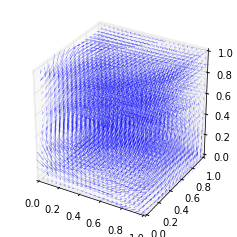

In [81]:
# 
# .. _demo_hyperelasticity:
# 
# Hyperelasticity
# ===============
# 
# This demo is implemented in a single Python file,
# :download:`demo_hyperelasticity.py`, which contains both the
# variational forms and the solver.
# 
# 
# Background
# ----------
# 
# See the section :ref:`hyperelasticity` for some mathematical
# background on this demo.
# 
# 
# Implementation
# --------------
# 
# This demo is implemented in the :download:`demo_hyperelasticity.py`
# file.
# 
# First, the required modules are imported::

import matplotlib.pyplot as plt
from dolfin import *

# The behavior of the form compiler FFC can be adjusted by prescribing
# various parameters. Here, we want to use the UFLACS backend of FFC::

# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"

# The first line tells the form compiler to use C++ compiler optimizations when
# compiling the generated code. The remainder is a dictionary of options which
# will be passed to the form compiler. It lists the optimizations strategies
# that we wish the form compiler to use when generating code.
# 
# .. index:: VectorFunctionSpace
# 
# First, we need a tetrahedral mesh of the domain and a function space
# on this mesh. Here, we choose to create a unit cube mesh with 25 ( =
# 24 + 1) vertices in one direction and 17 ( = 16 + 1) vertices in the
# other two direction. On this mesh, we define a function space of
# continuous piecewise linear vector polynomials (a Lagrange vector
# element space)::

# Create mesh and define function space
mesh = UnitCubeMesh(24, 16, 16)
V = VectorFunctionSpace(mesh, "Lagrange", 1)

# Note that :py:class:`VectorFunctionSpace
# <dolfin.functions.functionspace.VectorFunctionSpace>` creates a
# function space of vector fields. The dimension of the vector field
# (the number of components) is assumed to be the same as the spatial
# dimension, unless otherwise specified.
# 
# .. index:: compiled subdomain
# 
# The portions of the boundary on which Dirichlet boundary conditions
# will be applied are now defined::

# Mark boundary subdomians
left =  CompiledSubDomain("near(x[0], side) && on_boundary", side = 0.0)
right = CompiledSubDomain("near(x[0], side) && on_boundary", side = 1.0)

# The boundary subdomain ``left`` corresponds to the part of the
# boundary on which :math:`x=0` and the boundary subdomain ``right``
# corresponds to the part of the boundary on which :math:`x=1`. Note
# that C++ syntax is used in the :py:func:`CompiledSubDomain`
# <dolfin.compilemodules.subdomains.CompiledSubDomain>` function since
# the function will be automatically compiled into C++ code for
# efficiency. The (built-in) variable ``on_boundary`` is true for points
# on the boundary of a domain, and false otherwise.
# 
# .. index:: compiled expression
# 
# The Dirichlet boundary values are defined using compiled expressions::

# Define Dirichlet boundary (x = 0 or x = 1)
c = Constant((0.0, 0.0, 0.0))
r = Expression(("scale*0.0",
                "scale*(y0 + (x[1] - y0)*cos(theta) - (x[2] - z0)*sin(theta) - x[1])",
                "scale*(z0 + (x[1] - y0)*sin(theta) + (x[2] - z0)*cos(theta) - x[2])"),
                scale = 0.5, y0 = 0.5, z0 = 0.5, theta = pi/3, degree=2)

# Note the use of setting named parameters in the :py:class:`Expression
# <dolfin.functions.expression.Expression>` for ``r``.
# 
# The boundary subdomains and the boundary condition expressions are
# collected together in two :py:class:`DirichletBC
# <dolfin.fem.bcs.DirichletBC>` objects, one for each part of the
# Dirichlet boundary::

bcl = DirichletBC(V, c, left)
bcr = DirichletBC(V, r, right)
bcs = [bcl, bcr]

# The Dirichlet (essential) boundary conditions are constraints on the
# function space :math:`V`. The function space is therefore required as
# an argument to :py:class:`DirichletBC <dolfin.fem.bcs.DirichletBC>`.
# 
# .. index:: TestFunction, TrialFunction, Constant
# 
# Trial and test functions, and the most recent approximate displacement
# ``u`` are defined on the finite element space ``V``, and two objects
# of type :py:class:`Constant <dolfin.functions.constant.Constant>` are
# declared for the body force (``B``) and traction (``T``) terms::

# Define functions
du = TrialFunction(V)            # Incremental displacement
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement from previous iteration
B  = Constant((0.0, -0.5, 0.0))  # Body force per unit volume
T  = Constant((0.1,  0.0, 0.0))  # Traction force on the boundary

# In place of :py:class:`Constant <dolfin.functions.constant.Constant>`,
# it is also possible to use ``as_vector``, e.g.  ``B = as_vector( [0.0,
# -0.5, 0.0] )``. The advantage of Constant is that its values can be
# changed without requiring re-generation and re-compilation of C++
# code. On the other hand, using ``as_vector`` can eliminate some
# function calls during assembly.
# 
# With the functions defined, the kinematic quantities involved in the model
# are defined using UFL syntax::

# Kinematics
d = len(u)
I = Identity(d)             # Identity tensor
F = I + grad(u)             # Deformation gradient
C = F.T*F                   # Right Cauchy-Green tensor

# Invariants of deformation tensors
Ic = tr(C)
J  = det(F)

# Next, the material parameters are set and the strain energy density
# and the total potential energy are defined, again using UFL syntax::

# Elasticity parameters
E, nu = 10.0, 0.3
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))

# Stored strain energy density (compressible neo-Hookean model)
psi = (mu/2)*(Ic - 3) - mu*ln(J) + (lmbda/2)*(ln(J))**2

# Total potential energy
Pi = psi*dx - dot(B, u)*dx - dot(T, u)*ds

# Just as for the body force and traction vectors, :py:class:`Constant
# <dolfin.functions.constant.Constant>` has been used for the model
# parameters ``mu`` and ``lmbda`` to avoid re-generation of C++ code
# when changing model parameters. Note that ``lambda`` is a reserved
# keyword in Python, hence the misspelling ``lmbda``.
# 
# .. index:: directional derivative; derivative, taking variations; derivative, automatic differentiation; derivative
# 
# Directional derivatives are now computed of :math:`\Pi` and :math:`L`
# (see :eq:`first_variation` and :eq:`second_variation`)::

# Compute first variation of Pi (directional derivative about u in the direction of v)
F = derivative(Pi, u, v)

# Compute Jacobian of F
J = derivative(F, u, du)

# The complete variational problem can now be solved by a single call to
# :py:func:`solve <dolfin.fem.solving.solve>`::

# Solve variational problem
solve(F == 0, u, bcs, J=J)

# Finally, the solution ``u`` is saved to a file named
# ``displacement.pvd`` in VTK format, and the deformed mesh is plotted
# to the screen::

# Save solution in VTK format
file = File("displacement.pvd");
file << u;

# Plot solution
plot(u)
plt.show()
